In [1]:
using Random, Distributions, StatsBase

In [57]:
dim = Dict("m" => 50, "d" => 300);

In [3]:
function counting(m, d)
    return(zeros(m, m, d))
end

counting (generic function with 1 method)

In [77]:
function buckets_generation(parameters, dim)
    # Get Parameters
    S = parameters["S"]
    r = parameters["r"]
    delta = parameters["delta"]
    sigma = parameters["sigma"]
    tau = parameters["tau"]
    m = dim["m"]
    d = dim["d"]
    
    # h: step size, time_mesh: time
    h = tau / d
    
    # Geometric Brownian Motion
    min_stock_price = 0.0001
    max_stock_price = 5*S
    stock_price_mesh = [min_stock_price:(max_stock_price - min_stock_price)/(m - 1):max_stock_price;] .+ 
    zeros(dim["m"], dim["d"])
    
    return(stock_price_mesh)
end

buckets_generation (generic function with 1 method)

In [5]:
# Supposed now that M and e are historical observations of exercise multiples and forfeiture rates
M = [2.0] # [2.1, 2.2, 2.5, 2.6, 2.8, 2.9]
e = [0.06] # [0.08, 0.09, 0.095, 0.10, 0.10, 0.11]
parameters = Dict("S" => 50, "K" => 50,"r" => 0.075, "delta" => 0.0, "sigma" => 0.30, "tau" => 10, 
    "vest" => 3, "M" => M, "e" => e)
buckets = buckets_generation(parameters, dim);

In [6]:
function help_map_index(S, buckets)
    # S is a number at j th column 
    # buckets also j th column of buckets matrix
    min_index = []
    for s in S
        append!(min_index, findmin(abs.(s .- buckets))[2])
    end 
    return(transpose(min_index))
end 

function map_index(stock_price_path, buckets, trial, d)
    # Putting simulated stock price to its closest bucket.
    count = zeros(trial, d)
    for i = 1:d
        count[:, i] = help_map_index(stock_price_path[:, i], buckets[:, i])
    end  
    return(count)
end 

function gaussian_rand(trial, dim)
    # Sampling from Gaussian Distribution
    d = dim["d"]
    gaussian_rand = randn(trial, d)
    return(gaussian_rand, -gaussian_rand)
end

function lattice_generation(parameters, buckets, dim, gaussian_rand, trial)
    # Get Parameters
    S = parameters["S"]
    r = parameters["r"]
    delta = parameters["delta"]
    sigma = parameters["sigma"]
    tau = parameters["tau"]
    m = dim["m"]
    d = dim["d"]
    
    # h: step size, time_mesh: time
    eps = 10 ^ -20
    h = tau / d
    time_mesh = transpose([h:h:tau;])
    count = counting(m, d)
    
    # Simulation
    stock_price_path = zeros(trial, d)
    
    # Geometric Brownian Motion (Vectorization)
    stock_price_path[:, 1] .= S .+ (r .- delta) .* S .* h .+ (sigma .* sqrt(h) .* S) .* gaussian_rand[:, 1]
    for i = 2:d
        stock_price_path[:, i] .= stock_price_path[:, i - 1] .+ (r .- delta) .* h .* stock_price_path[:, i - 1] .+ 
        (sigma .* sqrt(h)) .* stock_price_path[:, i - 1] .* gaussian_rand[:, i]
    end
    
    # Lattice generation
    stock_price_path = map_index(stock_price_path, buckets, trial, d)
    
    for i = 1:(d - 1)  
        # From layer i to layer i + 1
        for (from, to) in zip(stock_price_path[:, i], stock_price_path[:, i + 1])
            count[floor(Int64, from), floor(Int64, to), i] += 1
        end 
        count[:, :, i] ./= (sum(count[:, :, i], dims = 2) .+ eps)
    end 
    
    # From first layer to root
    count_root = countmap(stock_price_path[:, 1])
    count_keys = collect(keys(count_root))
    count_val = [count_root[i] for i in count_keys]
    count_root = zeros(1, m)
    
    for (key, val) in zip(count_keys, count_val)
        count_root[1, floor(Int64, key)] = val
    end
    count_root ./= (sum(count_root, dims = 2) .+ eps)
    
    # Transition Tensor
    return(count, count_root)
end 

lattice_generation (generic function with 1 method)

In [651]:
trial = 20000
gaussian_rand_1, gaussian_rand_2 = gaussian_rand(trial, dim)

# Antithetic Variate
lattice_probability_1, root_probability_1 = lattice_generation(parameters, buckets, dim, gaussian_rand_1, trial);
lattice_probability_2, root_probability_2 = lattice_generation(parameters, buckets, dim, gaussian_rand_2, trial);

In [7]:
function discounting_process(parameters, buckets, lattice_probability, root_probability, dim)
    # Get Parameters
    S = parameters["S"]
    K = parameters["K"]
    r = parameters["r"]
    delta = parameters["delta"]
    sigma = parameters["sigma"]
    tau = parameters["tau"]
    vest = parameters["vest"]
    M = parameters["M"]
    e = parameters["e"]
    m = dim["m"]
    d = dim["d"]
    
    # h: step size, time_mesh: time
    h = tau / d

    # Payoff matrix
    payoff_mesh = zeros(m, d)
    for t = reverse(1:d)
        if t == d
            # When option is expired
            payoff_mesh[:, t] = max.(buckets[:, t] .- K, 0)
        else
            # Random sampling of parameters
            m_sample, e_sample = sample(M), sample(e)
            for i = 1:m
                # Probability weighted average payoff
                weighted_payoff = transpose(lattice_probability[i, :, t]) * payoff_mesh[:, t + 1]
                # American Call Payoff
#                 payoff_mesh[i, t] = max(buckets[i, t] - K, exp(-r * h) * weighted_payoff)
                # ESO payoff        
                if (t * h >= vest) && (buckets[i, t] >= K * m_sample)
                    payoff_mesh[i, t] = buckets[i, t] - K
                elseif (t * h >= vest) && (buckets[i, t] < K * m_sample)
                    payoff_mesh[i, t] = exp(- e_sample * h) * exp(-r * h) * weighted_payoff + 
                    (1- exp(-e_sample * h)) * max(buckets[i, t] - K, 0)
                else
                    payoff_mesh[i, t] = exp( - e_sample * h) * exp(-r * h) * weighted_payoff
                end
            end
        end
    end
    
    return(exp(-r * h) *(root_probability * payoff_mesh[:, 1]))
end 

discounting_process (generic function with 1 method)

In [653]:
option_price_1 = discounting_process(parameters, buckets, lattice_probability_1, root_probability_1, dim)
option_price_2 = discounting_process(parameters, buckets, lattice_probability_2, root_probability_2, dim)
antithetic_price = 0.5 * (option_price_1 + option_price_2)

1-element Array{Float64,1}:
 18.84823203225294

In [13]:
# Summary model
function cal_price(parameters, dim)

    buckets = buckets_generation(parameters, dim);
    trial = 10000
    
    gaussian_rand_1, gaussian_rand_2 = gaussian_rand(trial, dim)
    lattice_probability_1, root_probability_1 = lattice_generation(parameters, buckets, dim, gaussian_rand_1, trial)
    lattice_probability_2, root_probability_2 = lattice_generation(parameters, buckets, dim, gaussian_rand_2, trial)
    
    option_price_1 = discounting_process(parameters, buckets, lattice_probability_1, root_probability_1, dim)
    option_price_2 = discounting_process(parameters, buckets, lattice_probability_2, root_probability_2, dim)
    antithetic_price = 0.5 * (option_price_1 + option_price_2)
    
    return(antithetic_price)
end

cal_price (generic function with 1 method)

In [80]:
# Convergence analysis for d = 10, 20, ..., 300
d_dim = [i for i in 10:10:300]
p_dim = Any[]
i = 1
for d in d_dim
    push!(p_dim, cal_price(parameters, Dict("m" => 150, "d" => d)))
    print(i, "\n")
    i = i + 1
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


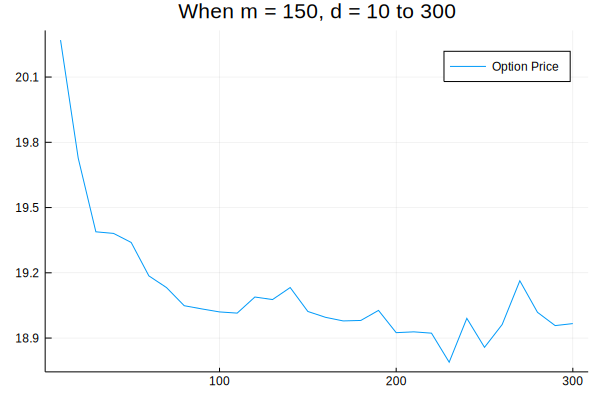

In [81]:
# Plot of Convergence Analysis
using Plots
x = [i for i in 1:30]
p = [p[1] for p in p_dim]
plot(x, p,
    title = "When m = 150, d = 10 to 300", label = "Option Price", 
    xtick = ([10, 20, 30], ["100", "200", "300"]))